<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [122]:
#Подключим необходимые библиотеки для проекта
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [123]:
def rmse(predictions, targets): 
        return np.sqrt(((predictions - targets) ** 2).mean())

In [124]:
#Откроем файл с данными. 
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [125]:
df.head(5)

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [127]:
#Проверим наличие пустых значений
df.isna().sum()

num_orders    0
dtype: int64

In [128]:
#Проверим упорядочен ли наш index
print(df.index.is_monotonic)

True


## Анализ

In [129]:
#Проведем ресемплирование по 1 часу, неделе и месяцу
monthly_stat= df.resample('1M').sum()
weekly_stat = df.resample('1W').sum()
hourly_stat = df.resample('1H').sum()

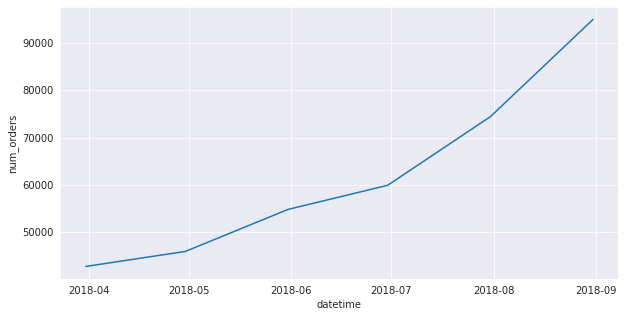

In [130]:
#Посмотрим на статистику заказов в разбивке по месяцам
sns.lineplot(x=monthly_stat.index,y=monthly_stat['num_orders'])

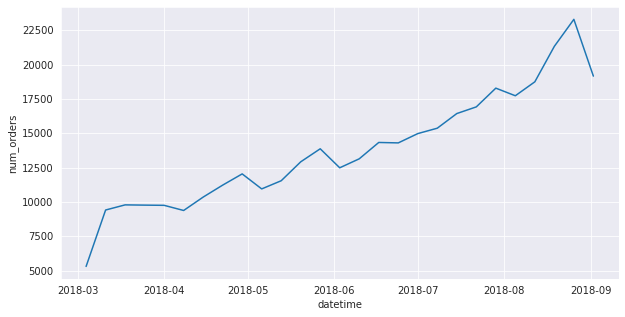

In [131]:
#Посмотрим на статистику заказов в разбивке по неделям
sns.lineplot(x=weekly_stat.index,y=weekly_stat['num_orders'])

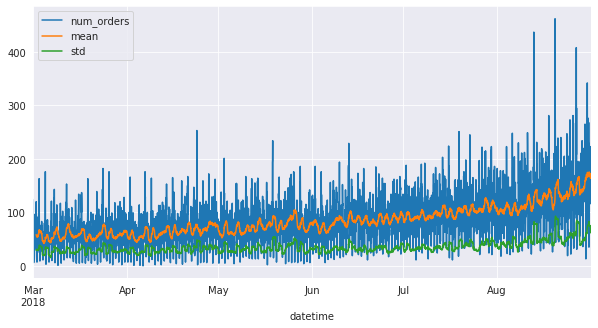

In [132]:
#Посмотрим на скользящее среднее и скользящее стандартное отклонение
hourly_stat['mean'] = hourly_stat['num_orders'].rolling(25).mean()
hourly_stat['std'] = hourly_stat['num_orders'].rolling(25).std()
hourly_stat.plot()

In [133]:
#Сделаем копию датасета чтобы провести анализ
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

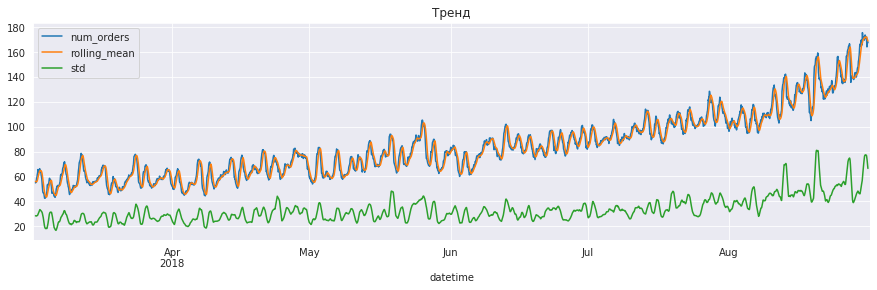

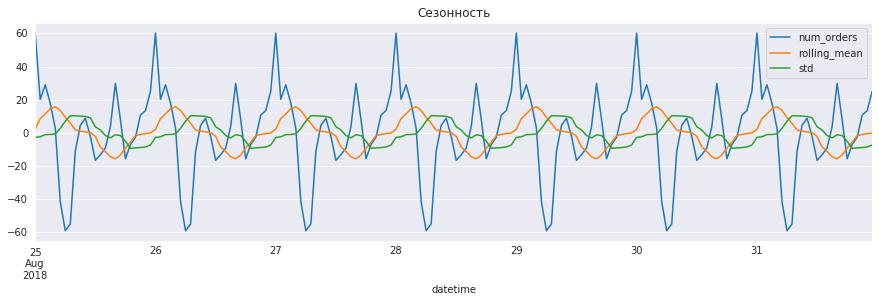

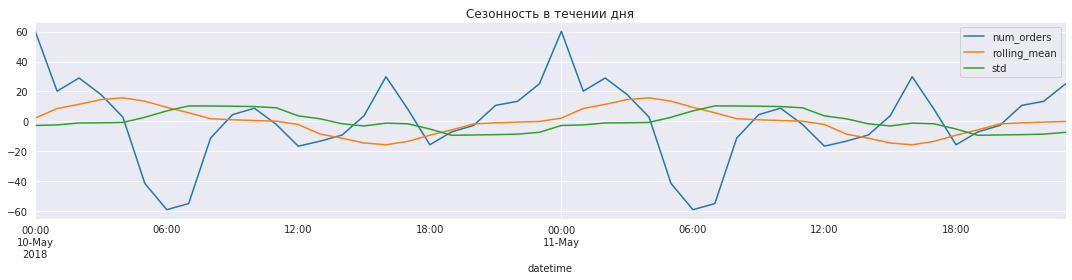

In [134]:
decomposed_df = seasonal_decompose(df_copy)
decomposed_df.trend.plot(title='Тренд', figsize=(15,4))
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,4))
plt.figure(figsize=(15, 4))
decomposed_df.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня')
plt.tight_layout()

**Вывод:**
- На графике "Тренд" можно увидеть, что количество заказов постепенно увеличивается.
- На графике сезонность разбитое на неделю видно, как количество заказов по выходным меньше чем в другие дни
- На третьем графике количество заказов к утру намного меньше, чем в другое время

## Обучение

In [135]:
#выполним ресемплирование по одному часу
df = df.resample('1H').sum()

#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [136]:
df.describe()

num_orders    dayofweek        hour        lag_1        lag_2  \
count  4416.000000  4416.000000  4416.00000  4415.000000  4414.000000   
mean     84.422781     3.005435    11.50000    84.395470    84.364069   
std      45.023853     1.990684     6.92297    44.992356    44.949043   
min       0.000000     0.000000     0.00000     0.000000     0.000000   
25%      54.000000     1.000000     5.75000    54.000000    54.000000   
50%      78.000000     3.000000    11.50000    78.000000    78.000000   
75%     107.000000     5.000000    17.25000   107.000000   107.000000   
max     462.000000     6.000000    23.00000   462.000000   462.000000   

             lag_3        lag_4        lag_5        lag_6        lag_7  \
count  4413.000000  4412.000000  4411.000000  4410.000000  4409.000000   
mean     84.347156    84.331369    84.319655    84.291837    84.261737   
std      44.940088    44.932942    44.931299    44.898387    44.858959   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      54.000000    54.000000    54.000000    54.000000    54.000000   
50%      78.000000    78.000000    78.000000    78.000000    78.000000   
75%     107.000000   107.000000   107.000000   107.000000   107.000000   
max     462.000000   462.000000   462.000000   462.000000   462.000000   

             lag_8        lag_9  rolling_mean  
count  4408.000000  4407.000000   4407.000000  
mean     84.236162    84.228954     84.320198  
std      44.831888    44.834421     30.263125  
min       0.000000     0.000000     25.888889  
25%      54.000000    54.000000     62.555556  
50%      78.000000    78.000000     79.888889  
75%     107.000000   107.000000    101.111111  
max     462.000000   462.000000    223.111111

In [137]:
#Разделим нашу таблилцу на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [138]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [139]:
#Проверим правильно ли расположены временные даннные, нельзя допустить в обучающую выборку данные из будущего
display(train.head(3))
display(test.head(3))

num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 09:00:00          69          3     9   34.0   15.0   12.0    6.0   
2018-03-01 10:00:00          64          3    10   69.0   34.0   15.0   12.0   
2018-03-01 11:00:00          96          3    11   64.0   69.0   34.0   15.0   

                     lag_5  lag_6  lag_7  lag_8  lag_9  rolling_mean  
datetime                                                              
2018-03-01 09:00:00   43.0   66.0   71.0   85.0  124.0     50.666667  
2018-03-01 10:00:00    6.0   43.0   66.0   71.0   85.0     44.555556  
2018-03-01 11:00:00   12.0    6.0   43.0   66.0   71.0     42.222222

num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-08-13 14:00:00         102          0    14  119.0   92.0  144.0  156.0   
2018-08-13 15:00:00         175          0    15  102.0  119.0   92.0  144.0   
2018-08-13 16:00:00         144          0    16  175.0  102.0  119.0   92.0   

                     lag_5  lag_6  lag_7  lag_8  lag_9  rolling_mean  
datetime                                                              
2018-08-13 14:00:00  137.0   91.0   39.0   66.0   83.0    103.000000  
2018-08-13 15:00:00  156.0  137.0   91.0   39.0   66.0    105.111111  
2018-08-13 16:00:00  144.0  156.0  137.0   91.0   39.0    117.222222

In [140]:
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3965 объектов, 12 признаков
Размер тестовой выборки: 442 объектов, 12 признаков


### Linear Regression

In [141]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE:', rmse(lr_predictions,y_test))

RMSE: 54.08758434757491


### LightGBMRegressor

In [142]:
#Попробуем подобрать параметры с помощью цикла
estimators = [50,100,200,300]
forleaves = [2,5,7,12]

for estim, leaves in zip(estimators, forleaves):
    lgb_model = lgb.LGBMRegressor(n_estimators=estim, num_leaves=leaves)
    lgb_model.fit(X,y)
    predictions = lgb_model.predict(X)
    print('RMSE with n_estimators : {} and num_leaves: {} is {}'.format(estim, leaves, rmse(predictions, y)))

RMSE with n_estimators : 50 and num_leaves: 2 is 29.447685769072727
RMSE with n_estimators : 100 and num_leaves: 5 is 22.159400472645576
RMSE with n_estimators : 200 and num_leaves: 7 is 19.212092776098753
RMSE with n_estimators : 300 and num_leaves: 12 is 14.89407898647034


In [143]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from random import randint, uniform

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]}

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 10,
    n_jobs = -1,
    iid = True,
    cv = tscv.split(X),
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X,y)
model.cv_results_
predictions = model.predict(X)
print('RMSE:', rmse(predictions, y))

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV]  max_depth=-1 ...................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...  max_depth=-1, score=(train=0.959, test=0.495), total=   1.0s
[CV]  max_depth=-1 ...................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ...  max_depth=-1, score=(train=0.927, test=0.438), total=   1.1s
[CV]  max_depth=-1 ...................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] ...  max_depth=-1, score=(train=0.893, test=0.380), total=   1.2s
[CV]  max_depth=-1 ...................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


[CV] ...  max_depth=-1, score=(train=0.862, test=0.405), total=   1.3s
[CV]  max_depth=2 ....................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.9s remaining:    0.0s


[CV] ....  max_depth=2, score=(train=0.959, test=0.495), total=   0.9s
[CV]  max_depth=2 ....................................................
[CV] ....  max_depth=2, score=(train=0.927, test=0.438), total=   1.1s
[CV]  max_depth=2 ....................................................
[CV] ....  max_depth=2, score=(train=0.893, test=0.380), total=   1.1s
[CV]  max_depth=2 ....................................................
[CV] ....  max_depth=2, score=(train=0.862, test=0.405), total=   1.6s


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   10.0s finished


RMSE: 14.753365161455976


## Тестирование

In [145]:
predictions = model.predict(X_test)
print('RMSE на тестовой выборке:', rmse(predictions,y_test))

RMSE на тестовой выборке: 43.820303611464006


Feature Importance

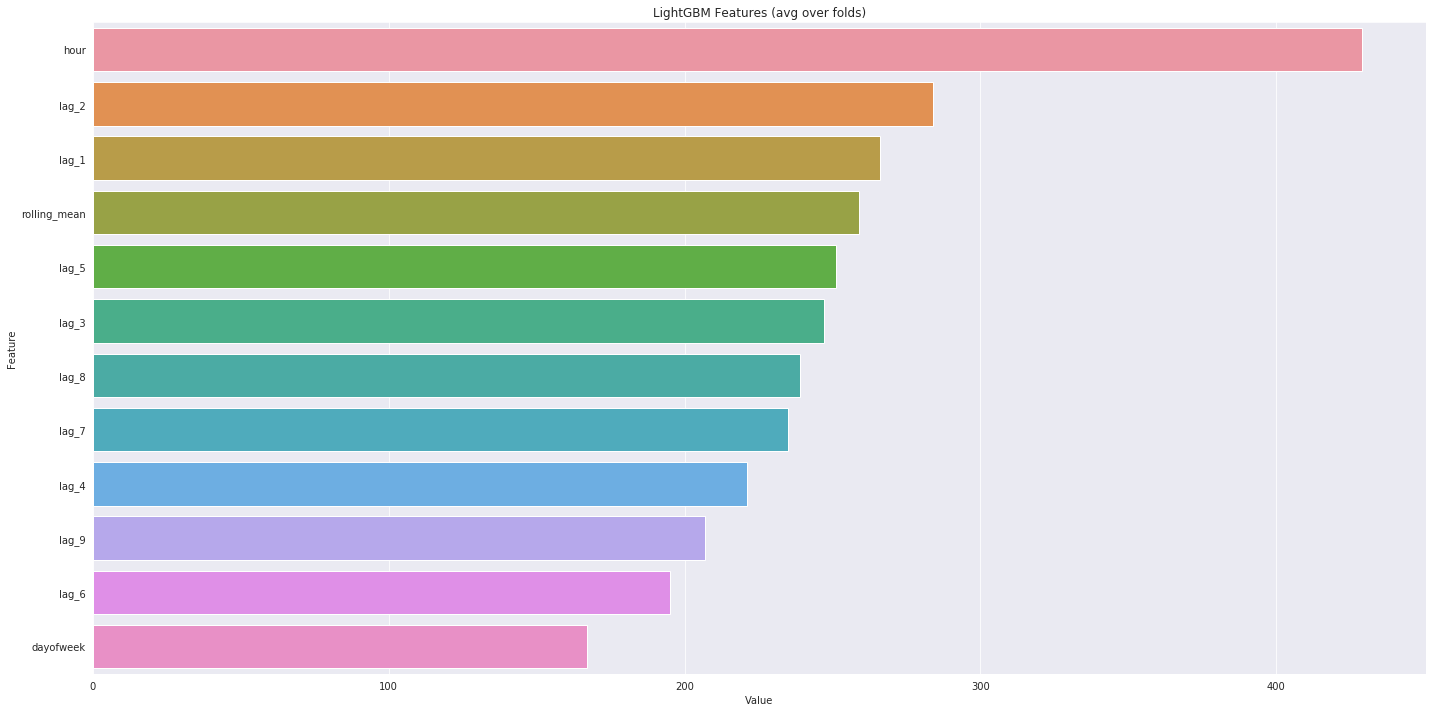

In [148]:
warnings.simplefilter(action='ignore', category=FutureWarning)
feature_imp = pd.DataFrame(sorted(zip(model.best_estimator_.feature_importances_,X_test.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

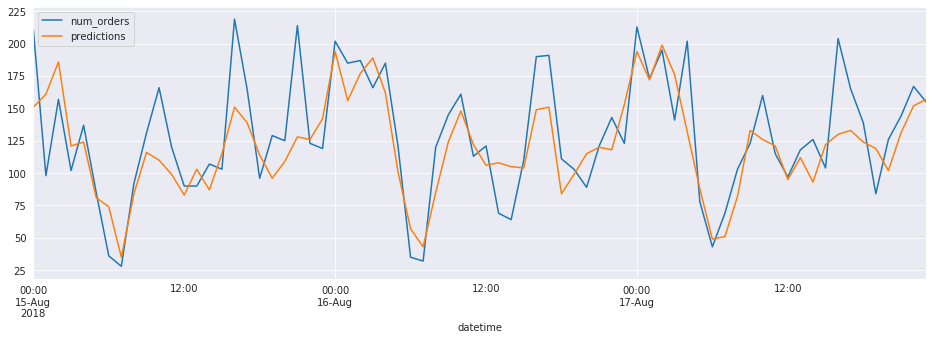

In [149]:
#выведем на графике реальное количество заказов в день и предсказанное нашей моделью. 
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

**Вывод:**
- Мы получили на выходе результат RMSE На тестовой выборке 41 - выполнили задание
- Как видно по графику, наша модель попадает в реальные заказы, есть конечно погрешности, но главное понял суть